In [45]:
import pandas as pd
import numpy as np
import seaborn
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBRegressor
import time
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv('tehranhouses.csv')
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [47]:
df.drop('Price(USD)', axis=1, inplace = True)
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price
1361,133,3,True,True,True,East Ferdows Boulevard,8000000000
318,60,1,True,True,True,Southern Janatabad,2250000000
2181,170,3,True,True,True,Pakdasht,1280000000
2780,50,2,False,True,False,Jeyhoon,730000000
3105,50,2,False,True,False,Komeil,730000000


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Area       3479 non-null   object
 1   Room       3479 non-null   int64 
 2   Parking    3479 non-null   bool  
 3   Warehouse  3479 non-null   bool  
 4   Elevator   3479 non-null   bool  
 5   Address    3456 non-null   object
 6   Price      3479 non-null   int64 
dtypes: bool(3), int64(2), object(2)
memory usage: 119.0+ KB


In [49]:
df.dropna(inplace=True)
df.shape

(3456, 7)

In [50]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',','',x))
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

In [51]:
df.describe()

,Area,Room,Price
count,3.456000e+03,3456.000000,3.456000e+03
mean,8.802191e+06,2.081308,5.379957e+09
std,3.177783e+08,0.759723,8.121729e+09
min,3.000000e+01,0.000000,3.600000e+06
25%,6.900000e+01,2.000000,1.420000e+09
50%,9.000000e+01,2.000000,2.900000e+09
75%,1.210000e+02,2.000000,6.000000e+09
max,1.616000e+10,5.000000,9.240000e+10


In [52]:
df[['Room' , 'Parking', 'Price']].groupby(['Room','Parking']).agg(['mean', 'min' ,'max']).reset_index()

Room Parking         Price                         
                         mean         min          max
0     0   False  9.769750e+09   165000000  75600000000
1     0    True  2.235000e+08   102000000    345000000
2     1   False  1.139678e+09     3600000  18000000000
3     1    True  2.031369e+09   110000000  22500000003
4     2   False  1.501674e+09   245000000  11500000000
5     2    True  3.592920e+09    55000000  32000000000
6     3   False  5.107865e+09   275000000  27000000000
7     3    True  1.115373e+10   295000000  74400000000
8     4   False  6.200000e+09  6200000000   6200000000
9     4    True  2.588149e+10  2400000000  92400000000
10    5   False  9.999000e+09   295000000  28000000000
11    5    True  3.797286e+10  3500000000  91000000000

<Figure size 800x500 with 0 Axes>

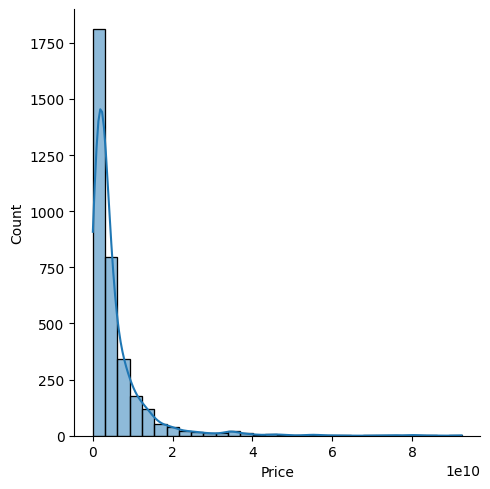

In [53]:
plt.figure(figsize=(8,5))
sns.displot(df["Price"], bins= 30, kde = True)

<Axes: >

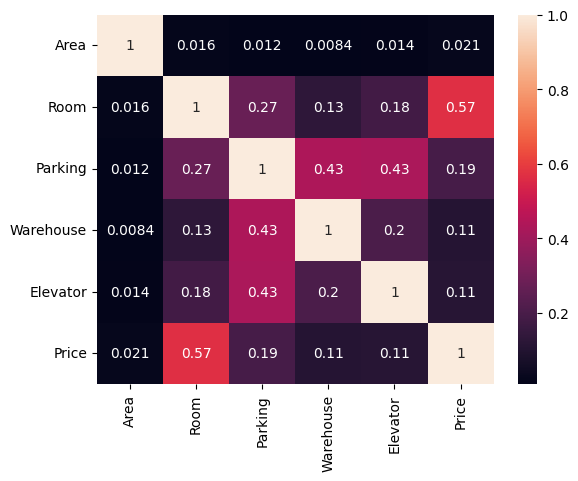

In [54]:
sns.heatmap(df.corr(), annot = True)

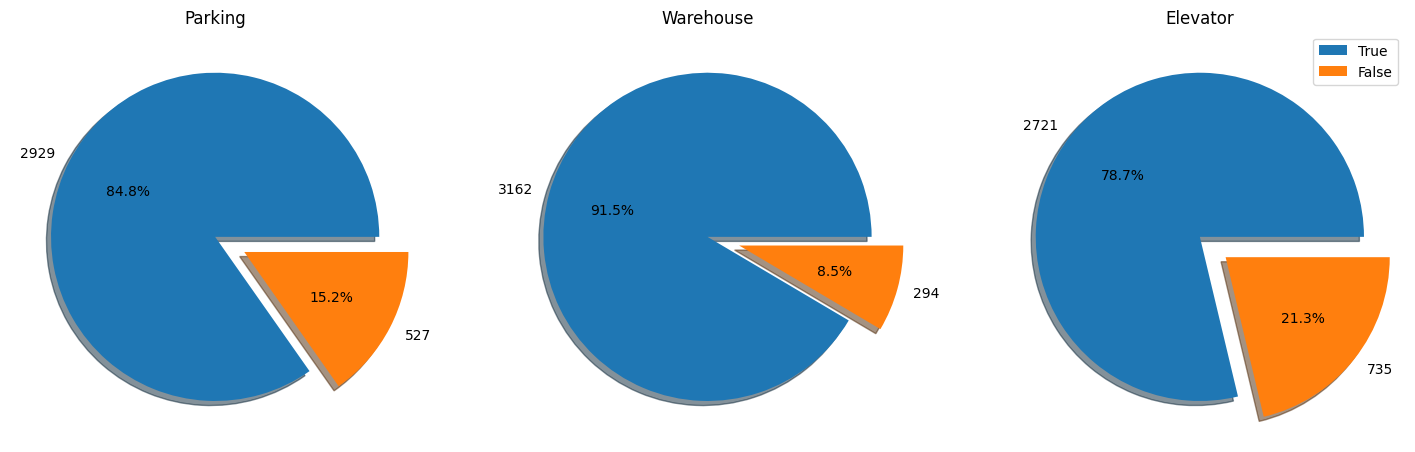

In [55]:
fig, ax = plt.subplots(ncols = 3, figsize=(18,6))

colums = ['Parking','Warehouse','Elevator']
for i in range(3):
  data = df[colums[i]].value_counts()
  ax[i].pie(data , labels=data.values ,explode=[0,0.2], shadow = True, autopct= '%1.1f%%' )
  plt.legend(labels = data.index)
  ax[i].set_title(f'{colums[i]}')

<Axes: >

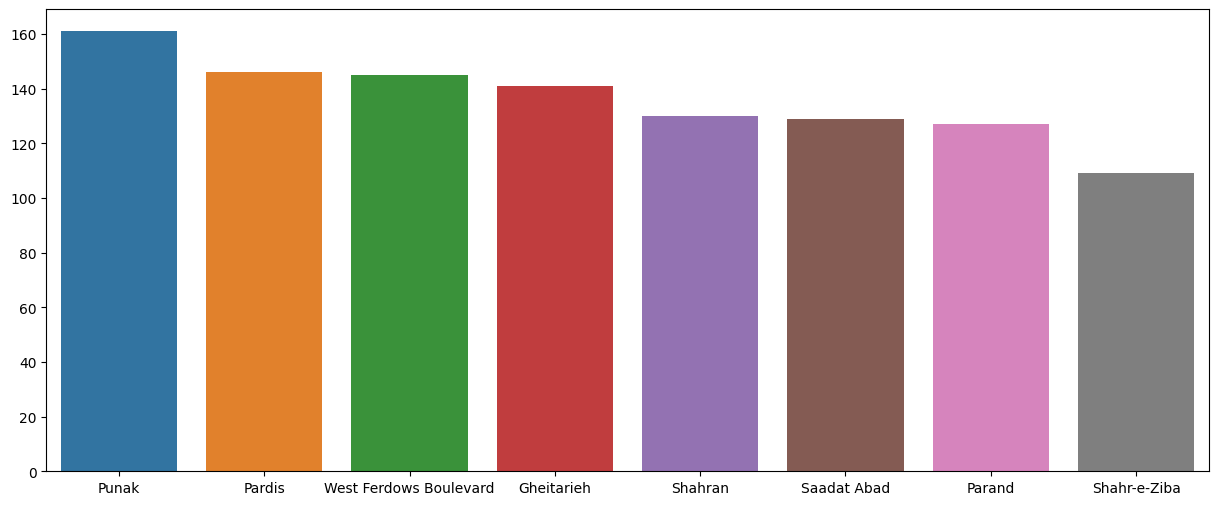

In [56]:
df3 = df['Address'].value_counts().copy()
df3 = df3[:8]
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(x=  df3.index , y = df3.values, ax=ax)

In [57]:
df.sort_values('Price', ascending=False)[['Address','Price']].head(10)

,Address,Price
1707,Zaferanieh,92400000000
1810,Abazar,91000000000
430,Lavasan,85000000000
819,Ekhtiarieh,81600000000
1332,Niavaran,80500000000
1694,Zafar,80000000000
3051,Dorous,79500000000
3107,Tajrish,75600000000
831,Mahmoudieh,75000000000
2394,Aqdasieh,74400000000


In [58]:
df.sort_values('Price', ascending=True)[['Address','Price']].head(5)

,Address,Price
136,Qarchak,3600000
2770,Ozgol,55000000
731,Pardis,60000000
2721,Parand,102000000
2201,Andisheh,110000000


In [59]:
df[['Parking','Warehouse','Elevator']] = df[['Parking','Warehouse','Elevator']].astype('int64')
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price
827,147,3,1,1,1,Jordan,8700000000
1755,155,3,1,1,1,Dorous,9800000000
665,70,2,1,1,1,Amirieh,1630000000
2098,50,1,1,1,0,Shahrake Qods,360000000
1319,97,2,1,1,1,Pardis,770000000


In [60]:
round(df.skew())

Area         44.0
Room          1.0
Parking      -2.0
Warehouse    -3.0
Elevator     -1.0
Price         5.0
dtype: float64

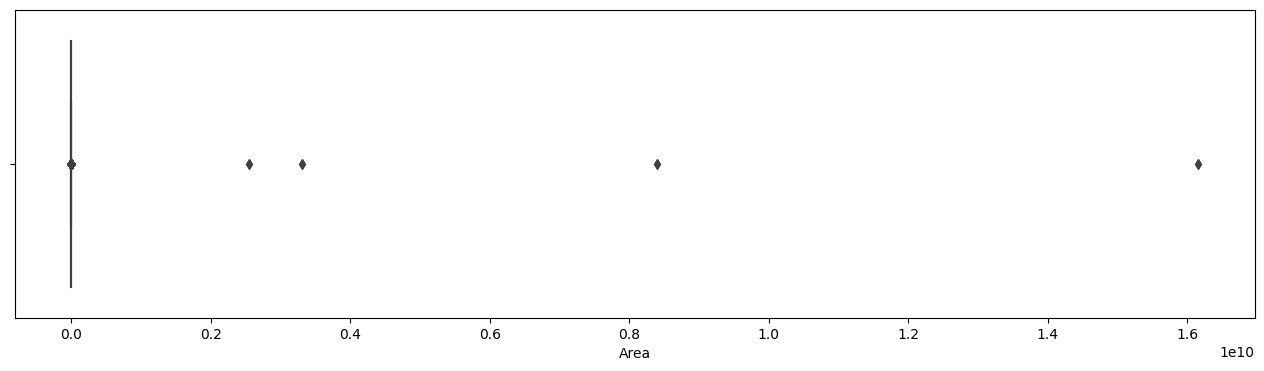

<Axes: xlabel='Price'>

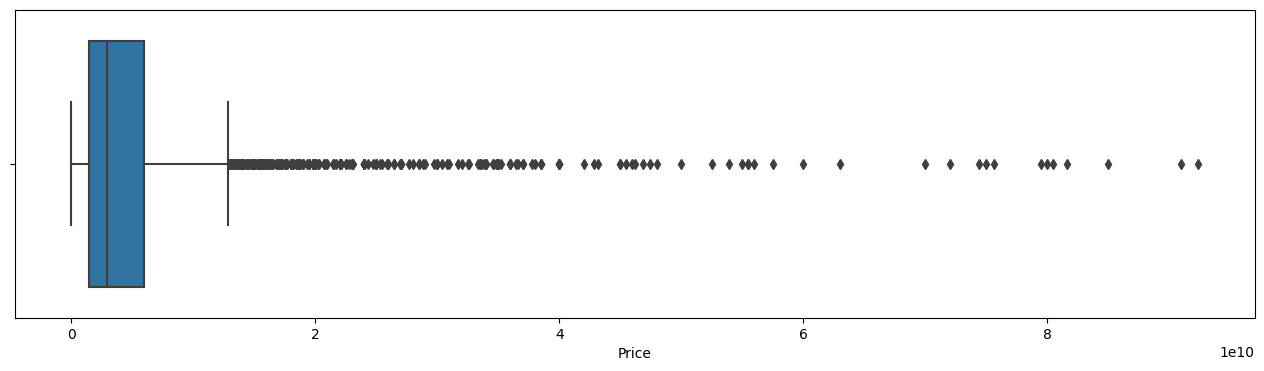

In [61]:
plt.figure(figsize=(16,4))

sns.boxplot(x=df["Area"])
plt.show()

plt.figure(figsize=(16,4))
sns.boxplot(x= df["Price"])

In [62]:
df.shape

(3456, 7)

In [63]:
def handel_outlier(x) -> tuple:
  Q1 = x.quantile(0.25)
  Q3 = x.quantile(0.75)
  IQR = Q3 - Q1

  lower = Q1 - (1.5*IQR)
  upper = Q3 + (1.5*IQR)

  return lower, upper

low_area, upp_area = handel_outlier(df['Area'])
low_price, upp_price = handel_outlier(df['Price'])

In [64]:
df_final = df[
    (df['Area'] < upp_area) &
    (df['Area'] > low_area) &
    (df['Price'] < upp_price) &
    (df['Price'] > low_price)
]
df_final.shape

(3090, 7)

In [65]:
address_dummy = pd.get_dummies(df_final['Address'])
df_final = pd.concat([df_final,address_dummy], axis=1)
df_final = df_final.drop('Address',axis=1)
df_final.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1850000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60,1,1,1,1,1850000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79,2,1,1,1,550000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,95,2,1,1,1,902500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,123,2,1,1,1,7000000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X = df_final.drop(columns = 'Price')
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state= 42)

In [67]:
def find_parametrs(model, paramets) -> None:
  start = time.time()

  grid = GridSearchCV(model,
                      param_grid = paramets,
                      refit=True,
                      cv = KFold(shuffle = True, random_state=1),
                      n_jobs = -1
                      )

  grid.fit(X_train, y_train)
  y_train_pred = grid.predict(X_train)
  predctions = grid.predict(X_test)

  train_score = grid.score(X_train, y_train)
  test_score = grid.score(X_test, y_test)
  RSME = np.sqrt(mean_squared_error(y_test,predctions))

  end = time.time()

  print(grid.best_params_)
  print('-'*10)
  print('train_score:',train_score)
  print('test_score:',test_score)
  print('RSME',RSME)
  print('time:',end - start)



In [110]:
xgb = XGBRegressor(n_jobs=-1)
param = {'n_estimators':[100,300,500,1000],
         'learning_rate':[0.2,0.1,0.5],
         'colsample_bytree':[1],
         'max_depth' : [3,4,5,6],
         'gamma' : [0]}

find_parametrs(xgb, param)


{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}
----------
train_score: 0.936703441767396
test_score: 0.8706516797922892
RSME 1046661673.2185485
time: 1575.4471180438995


In [68]:
xgb = XGBRegressor(n_estimators=500, n_jobs = -1, max_depth= 3,learning_rate= 0.2, gamma= 0,colsample_bytree= 1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
import joblib

In [29]:
joblib.dump(xgb,'XGBosst Model.joblib')

['XGBosst Model.joblib']